In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

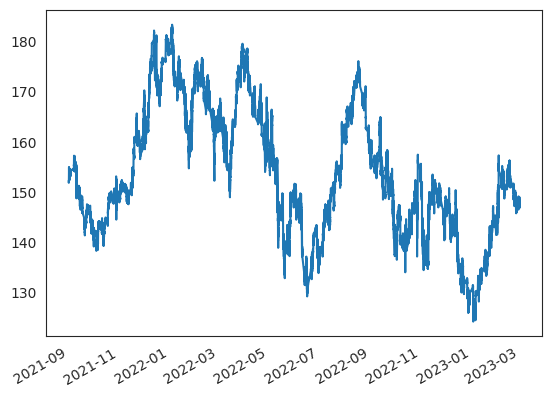

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_3,ema_5,ema_8,ema_9,ema_13,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,0.002633,0.002630,151.956,0.002330,151.911111,0.002626,151.874286,0.002869,151.8499,0.003030,151.862701,0.002945,151.874676,0.002866,152.096413,152.018578,151.964327,151.953148,151.923549,151.894996,151.867887,0.002963,0.003095,0.003161,-0.03,-0.000197,0.06,0.11,0.001313,97.117392,92.108647,88.907688,0.072060,0.027698,0.044362,0.043925,0.012360,0.031565,0.093550,0.000614,0.053679,0.000352,0.031763,0.000209,84.467536,3.401602,28.421520,77.491111,7.239535,19.072892,69.968105,11.638923,14.391505,151.674268,152.077732,0.002657,151.573401,152.178599,0.003985,151.714905,151.984895,0.001778,1.529217e+10,0.613270,1.023843,1.224605,152.40,151.80,0.000591,0.003348,19082.0,125.599677,27680.000000,182.256001,0.000579,0.000339,0.948276,0.871648,0.948276,0.816092,466.666667,500.000000,85.708219,81.744827,0.262026,0.233686,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.889248,151.866828,0.007699,0.001677,151.897444,151.836322,151.958567,0.000805,151.897444,151.815948,151.978941,0.001073,151.820000,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,0.000000,0.000000,152.048,0.001723,151.961111,0.002296,151.896667,0.002721,151.8593,0.002968,151.866702,0.002919,151.876876,0.002852,152.203206,152.115719,152.041143,152.024518,151.978756,151.932724,151.885225,0.003029,0.003095,0.003095,0.00,0.000000,0.00,0.00,0.000000,97.117392,92.108647,88.907688,0.106679,0.054025,0.052654,0.071035,0.024095,0.046941,0.080186,0.000526,0.049844,0.000327,0.030628,0.000201,84.467536,3.401602,37.540956,77.491111,7.239535,23.632803,69.968105,11.638923,16.430226,151.624973,152.175027,0.003621,151.487459,152.312541,0.005432,151.672758,152.045842,0.002457,1.529217e+10,0.376288,0.576864,0.696184,152.40,151.80,0.000591,0.003348,17295.0,113.788242,26841.000000,176.705655,0.000579,0.000339,0.896552,0.911239,0.896552,0.892720,235.338654,336.051648,85.801987,86.061612,0.295809,0.278437,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.905092,151.875656,0.013173,0.002735,151.936735,151.878669,151.994802,0.000764,151.936735,151.859314,152.014157,0.001019,151.820000,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,-0.000066,-0.000066,152.138,0.001065,152.011111,0.001900,151.919048,0.002508,151.8687,0.002840,151.870602,0.002827,151.879026,0.002772,152.251603,152.177146,152.098667,152.079614,152.024648,151.966113,151.901491,0.002963,0.002897,0.003096,0.00,0.000000,0.00,0.00,0.000000,94.266696,90.188784,87.281932,0.122091,0.076714,0.045377,0.090669,0.037410,0.053259,0.070159,0.000461,0.046998,0.000309,0.029892,0.000196,82.747626,5.368519,44.722948,76.313395,8.6

In [3]:
## INDICATORS STRATEGIES DF ##

df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################

df_inds.close.plot()
plt.show()
df_inds

In [4]:
# # ##### 101 ######
# {'reset_peak': (0, 0),
#  'rsi_min_thresh': (23, 33),
#  'rsi_max_thresh': (50, 50),
#  'adx_thresh': (54.52567693462544, 54.58429306537457),
#  'atr_mult': (17.198027201233764, 18.036792798766236),
#  'vwap_atr_mult': (0.6750593038610649, 0.7075606961389352),
#  'buy_factor': (0.8830246662745681, 0.9099453337254318),
#  'sell_factor': (0.023283027013426515, 0.039126972986573486),
#  'trailstop_pct': (24.136946735051815, 32.26776326494819),
#  'sign_thresh_pair': {'categorical': ['ema_3|ema_8']}}

In [5]:
# Pre-compute per-day slices once
groups = df_inds.groupby(df_inds.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    reset_peak       = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 23, 33)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 49), 51)
    adx_thresh       = trial.suggest_float("adx_thresh", 54.5, 54.6)
    atr_mult         = trial.suggest_float("atr_mult", 17, 18, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", 0.67, 0.72)
    buy_factor       = trial.suggest_float("buy_factor", 0.88, 0.91)
    sell_factor      = trial.suggest_float("sell_factor", 0.02, 0.04)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 24.0, 32.0)
    sign_thresh_pair = trial.suggest_categorical("sign_thresh_pair",[ 
                                                    "ema_3|ema_8",
                                                    # "ema_5|ema_13",
                                                    # "ema_9|ema_21",
                                                    # "ema_21|ema_50",
                                                    # "roc_5|ema_21"
                                                    # "roc_5|0.0"
                                                    # "macd_line_12_26_9|0.0"
                                                    # "macd_diff_6_13_5|0.0"
                                                    # "rsi_14|50.0"
                                                    # "rsi_6|50.0"
                                                ])
    col_signal, sign_thresh = sign_thresh_pair.split("|")
    try: 
        sign_thresh = float(sign_thresh) # convert numeric thresholds (only if it´s numeric)
    except ValueError:
        pass # the threshold is a signal
    
    print('-' * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            col_signal      = col_signal,
            sign_thresh     = sign_thresh,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strats._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strats._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)


Baseline mean daily B&H: -9.5162


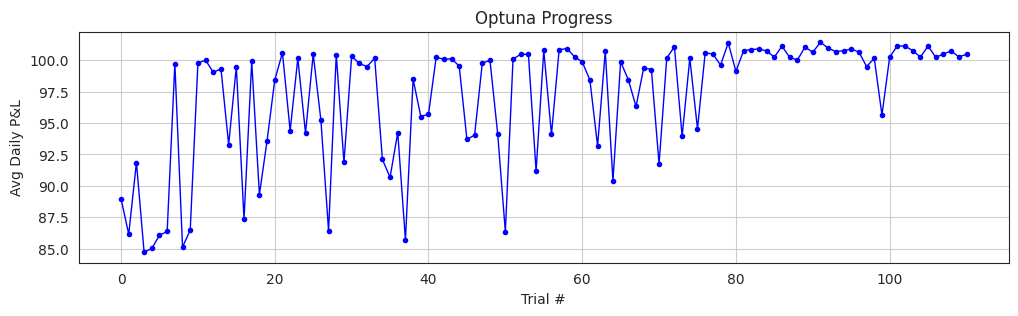

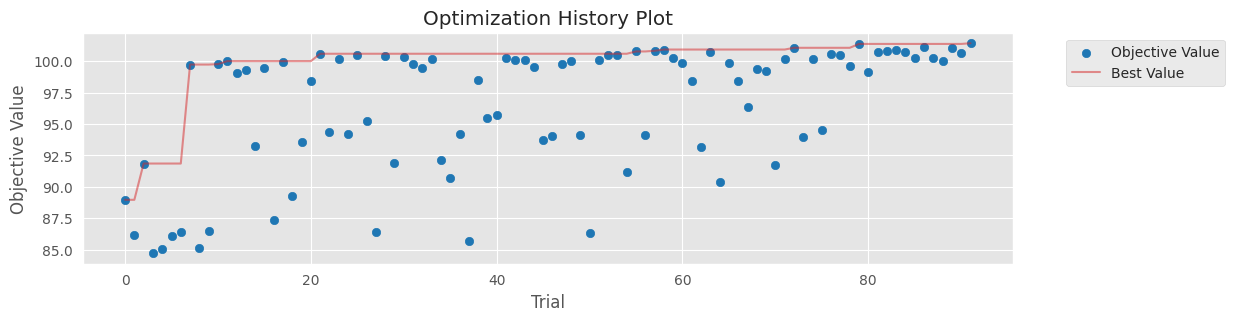

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.50755272414452; atr_mult=17.79958057656133; vwap_atr_mult=0.6892739632113863; buy_factor=0.883672885348524; sell_factor=0.03956373053758715; trailstop_pct=29.74649948440438; sign_thresh_pair=ema_3|ema_8


Trial 0: 100%|██████████| 375/375 [01:16<00:00,  4.92it/s]


[Results] mean_pnl:80.2219 mean_bh:-8.7491 mean_excess:88.9710 improv_vs_bh:1016.92%
Action counts: {'Buy': 693, 'Sell': 16812, 'Hold': 333206}
Best trial is: 0 with best_val: 88.9710
[save_results] wrote optuna_results/AAPL_88.971_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_88.971_pred_IND.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=54.59764153946868; atr_mult=17.225272654533583; vwap_atr_mult=0.7096042697800344; buy_factor=0.9012579893639099; sell_factor=0.02541818975198064; trailstop_pct=29.958415112589844; sign_thresh_pair=ema_3|ema_8


Trial 1: 100%|██████████| 375/375 [00:53<00:00,  6.98it/s]


[Results] mean_pnl:77.4022 mean_bh:-8.7491 mean_excess:86.1513 improv_vs_bh:984.69%
Action counts: {'Buy': 633, 'Sell': 21291, 'Hold': 328787}
Best trial is: 0 with best_val: 88.9710
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.50451209090038; atr_mult=17.879841605585796; vwap_atr_mult=0.711541883927923; buy_factor=0.8978753468655046; sell_factor=0.03355502869007417; trailstop_pct=26.974513324495838; sign_thresh_pair=ema_3|ema_8


Trial 2: 100%|██████████| 375/375 [01:13<00:00,  5.08it/s]


[Results] mean_pnl:83.1103 mean_bh:-8.7491 mean_excess:91.8594 improv_vs_bh:1049.93%
Action counts: {'Buy': 628, 'Sell': 17776, 'Hold': 332307}
Best trial is: 2 with best_val: 91.8594
[save_results] wrote optuna_results/AAPL_91.8594_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_91.8594_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.51317669587966; atr_mult=17.868327424453245; vwap_atr_mult=0.7128849801939495; buy_factor=0.9036008450450334; sell_factor=0.03128793697942181; trailstop_pct=25.419297877013996; sign_thresh_pair=ema_3|ema_8


Trial 3: 100%|██████████| 375/375 [01:14<00:00,  5.05it/s]


[Results] mean_pnl:75.9680 mean_bh:-8.7491 mean_excess:84.7171 improv_vs_bh:968.30%
Action counts: {'Buy': 638, 'Sell': 18900, 'Hold': 331173}
Best trial is: 2 with best_val: 91.8594
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.51924501088793; atr_mult=17.389344001008457; vwap_atr_mult=0.7094804725812441; buy_factor=0.9036307977940145; sell_factor=0.034962829763699216; trailstop_pct=29.774822815749996; sign_thresh_pair=ema_3|ema_8


Trial 4: 100%|██████████| 375/375 [01:16<00:00,  4.92it/s]


[Results] mean_pnl:76.2691 mean_bh:-8.7491 mean_excess:85.0182 improv_vs_bh:971.74%
Action counts: {'Buy': 643, 'Sell': 18128, 'Hold': 331940}
Best trial is: 2 with best_val: 91.8594
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=54.544035744188704; atr_mult=17.783199989092836; vwap_atr_mult=0.6716260995658675; buy_factor=0.8860961789190606; sell_factor=0.020048070785506723; trailstop_pct=27.291187536055652; sign_thresh_pair=ema_3|ema_8


Trial 5: 100%|██████████| 375/375 [01:11<00:00,  5.23it/s]


[Results] mean_pnl:77.3163 mean_bh:-8.7491 mean_excess:86.0654 improv_vs_bh:983.71%
Action counts: {'Buy': 636, 'Sell': 22486, 'Hold': 327589}
Best trial is: 2 with best_val: 91.8594
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.505089054980985; atr_mult=17.64139743144872; vwap_atr_mult=0.6809430897688262; buy_factor=0.9015813149791486; sell_factor=0.02123670682454182; trailstop_pct=24.691361241261642; sign_thresh_pair=ema_3|ema_8


Trial 6: 100%|██████████| 375/375 [01:43<00:00,  3.61it/s]


[Results] mean_pnl:77.6182 mean_bh:-8.7491 mean_excess:86.3673 improv_vs_bh:987.16%
Action counts: {'Buy': 610, 'Sell': 22043, 'Hold': 328058}
Best trial is: 2 with best_val: 91.8594
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.552789816095; atr_mult=17.326153729355052; vwap_atr_mult=0.6903333883908814; buy_factor=0.8972774122687707; sell_factor=0.03381591707324657; trailstop_pct=27.18453915299535; sign_thresh_pair=ema_3|ema_8


Trial 7: 100%|██████████| 375/375 [01:04<00:00,  5.80it/s]


[Results] mean_pnl:90.9924 mean_bh:-8.7491 mean_excess:99.7415 improv_vs_bh:1140.02%
Action counts: {'Buy': 637, 'Sell': 18040, 'Hold': 332034}
Best trial is: 7 with best_val: 99.7415
[save_results] wrote optuna_results/AAPL_99.7415_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_99.7415_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=54.55905692642825; atr_mult=17.65011250041037; vwap_atr_mult=0.6745434495128649; buy_factor=0.9053281037626107; sell_factor=0.02040893552439496; trailstop_pct=29.68688760707829; sign_thresh_pair=ema_3|ema_8


Trial 8: 100%|██████████| 375/375 [01:11<00:00,  5.25it/s]


[Results] mean_pnl:76.3780 mean_bh:-8.7491 mean_excess:85.1271 improv_vs_bh:972.98%
Action counts: {'Buy': 629, 'Sell': 23298, 'Hold': 326784}
Best trial is: 7 with best_val: 99.7415
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=54.51032098836458; atr_mult=17.342456835454723; vwap_atr_mult=0.6773814379366563; buy_factor=0.8897224390125452; sell_factor=0.02324919853881537; trailstop_pct=26.29027745430547; sign_thresh_pair=ema_3|ema_8


Trial 9: 100%|██████████| 375/375 [01:34<00:00,  3.95it/s]


[Results] mean_pnl:77.7254 mean_bh:-8.7491 mean_excess:86.4745 improv_vs_bh:988.38%
Action counts: {'Buy': 635, 'Sell': 21336, 'Hold': 328740}
Best trial is: 7 with best_val: 99.7415
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57223553654779; atr_mult=17.017533813841602; vwap_atr_mult=0.6973773134953405; buy_factor=0.8917721648854029; sell_factor=0.027816280246902556; trailstop_pct=31.65300819721597; sign_thresh_pair=ema_3|ema_8


Trial 10: 100%|██████████| 375/375 [02:04<00:00,  3.01it/s]


[Results] mean_pnl:91.0258 mean_bh:-8.7491 mean_excess:99.7749 improv_vs_bh:1140.40%
Action counts: {'Buy': 641, 'Sell': 20056, 'Hold': 330014}
Best trial is: 10 with best_val: 99.7749
[save_results] wrote optuna_results/AAPL_99.7749_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_99.7749_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57204227306062; atr_mult=17.01768326858657; vwap_atr_mult=0.6975889069413473; buy_factor=0.8927633685533879; sell_factor=0.027364646452460107; trailstop_pct=31.951034169798948; sign_thresh_pair=ema_3|ema_8


Trial 11: 100%|██████████| 375/375 [01:31<00:00,  4.08it/s]


[Results] mean_pnl:91.2655 mean_bh:-8.7491 mean_excess:100.0145 improv_vs_bh:1143.14%
Action counts: {'Buy': 640, 'Sell': 20222, 'Hold': 329849}
Best trial is: 11 with best_val: 100.0145
[save_results] wrote optuna_results/AAPL_100.0145_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_100.0145_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57964292726683; atr_mult=17.008472005885018; vwap_atr_mult=0.6990603462645438; buy_factor=0.8915640620540777; sell_factor=0.026997849224820673; trailstop_pct=31.895961807079512; sign_thresh_pair=ema_3|ema_8


Trial 12: 100%|██████████| 375/375 [01:32<00:00,  4.04it/s]


[Results] mean_pnl:90.2918 mean_bh:-8.7491 mean_excess:99.0409 improv_vs_bh:1132.01%
Action counts: {'Buy': 641, 'Sell': 20336, 'Hold': 329734}
Best trial is: 11 with best_val: 100.0145
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.57343035571852; atr_mult=17.000807955615986; vwap_atr_mult=0.6999703770397013; buy_factor=0.8930189470414072; sell_factor=0.029088830791930993; trailstop_pct=31.871980005008442; sign_thresh_pair=ema_3|ema_8


Trial 13: 100%|██████████| 375/375 [01:00<00:00,  6.18it/s]


[Results] mean_pnl:90.5792 mean_bh:-8.7491 mean_excess:99.3283 improv_vs_bh:1135.30%
Action counts: {'Buy': 642, 'Sell': 19636, 'Hold': 330433}
Best trial is: 11 with best_val: 100.0145
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.573108250285436; atr_mult=17.181450979241184; vwap_atr_mult=0.7195227907954167; buy_factor=0.888789086191808; sell_factor=0.02792636651037715; trailstop_pct=30.933081149692203; sign_thresh_pair=ema_3|ema_8


Trial 14: 100%|██████████| 375/375 [01:50<00:00,  3.39it/s]


[Results] mean_pnl:84.5402 mean_bh:-8.7491 mean_excess:93.2893 improv_vs_bh:1066.27%
Action counts: {'Buy': 650, 'Sell': 19848, 'Hold': 330213}
Best trial is: 11 with best_val: 100.0145
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.59442032567579; atr_mult=17.115714560948593; vwap_atr_mult=0.6944704458298915; buy_factor=0.88001156909343; sell_factor=0.024993031789023727; trailstop_pct=28.477008216145357; sign_thresh_pair=ema_3|ema_8


Trial 15: 100%|██████████| 375/375 [01:21<00:00,  4.58it/s]


[Results] mean_pnl:90.7498 mean_bh:-8.7491 mean_excess:99.4989 improv_vs_bh:1137.25%
Action counts: {'Buy': 692, 'Sell': 21022, 'Hold': 328997}
Best trial is: 11 with best_val: 100.0145
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=54.534825016264655; atr_mult=17.507938083429483; vwap_atr_mult=0.703101441358339; buy_factor=0.8955902855434104; sell_factor=0.030977570620948174; trailstop_pct=31.191470673243366; sign_thresh_pair=ema_3|ema_8


Trial 16: 100%|██████████| 375/375 [01:25<00:00,  4.40it/s]


[Results] mean_pnl:78.5855 mean_bh:-8.7491 mean_excess:87.3346 improv_vs_bh:998.21%
Action counts: {'Buy': 624, 'Sell': 18407, 'Hold': 331680}
Best trial is: 11 with best_val: 100.0145
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.562840033832146; atr_mult=17.078237261868527; vwap_atr_mult=0.6849315808654255; buy_factor=0.886493554683049; sell_factor=0.026507371174992574; trailstop_pct=28.887394456740452; sign_thresh_pair=ema_3|ema_8


Trial 17: 100%|██████████| 375/375 [01:10<00:00,  5.28it/s]


[Results] mean_pnl:91.1593 mean_bh:-8.7491 mean_excess:99.9084 improv_vs_bh:1141.93%
Action counts: {'Buy': 664, 'Sell': 20490, 'Hold': 329557}
Best trial is: 11 with best_val: 100.0145
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=54.56129985377362; atr_mult=17.146706756105967; vwap_atr_mult=0.6838598882871266; buy_factor=0.8851672675260399; sell_factor=0.023509439231730735; trailstop_pct=28.761256743197404; sign_thresh_pair=ema_3|ema_8


Trial 18: 100%|██████████| 375/375 [00:55<00:00,  6.74it/s]


[Results] mean_pnl:80.5568 mean_bh:-8.7491 mean_excess:89.3059 improv_vs_bh:1020.74%
Action counts: {'Buy': 650, 'Sell': 21358, 'Hold': 328703}
Best trial is: 11 with best_val: 100.0145
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.5323403772624; atr_mult=17.26480819107226; vwap_atr_mult=0.6848426808637161; buy_factor=0.8820915848503502; sell_factor=0.03712668752404675; trailstop_pct=30.51264824567089; sign_thresh_pair=ema_3|ema_8


Trial 19: 100%|██████████| 375/375 [01:30<00:00,  4.16it/s]


[Results] mean_pnl:84.8594 mean_bh:-8.7491 mean_excess:93.6084 improv_vs_bh:1069.92%
Action counts: {'Buy': 700, 'Sell': 17210, 'Hold': 332801}
Best trial is: 11 with best_val: 100.0145
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.5873953399488; atr_mult=17.457844494398877; vwap_atr_mult=0.6927916178088195; buy_factor=0.8881077013930524; sell_factor=0.02578522256981845; trailstop_pct=28.816924988217295; sign_thresh_pair=ema_3|ema_8


Trial 20: 100%|██████████| 375/375 [01:15<00:00,  4.97it/s]


[Results] mean_pnl:89.6858 mean_bh:-8.7491 mean_excess:98.4349 improv_vs_bh:1125.09%
Action counts: {'Buy': 651, 'Sell': 20534, 'Hold': 329526}
Best trial is: 11 with best_val: 100.0145
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.56614902833434; atr_mult=17.080629676635798; vwap_atr_mult=0.7013573261368566; buy_factor=0.9096235582864973; sell_factor=0.029270850571472003; trailstop_pct=31.143554166266014; sign_thresh_pair=ema_3|ema_8


Trial 21: 100%|██████████| 375/375 [02:02<00:00,  3.05it/s]


[Results] mean_pnl:91.8531 mean_bh:-8.7491 mean_excess:100.6022 improv_vs_bh:1149.86%
Action counts: {'Buy': 621, 'Sell': 19543, 'Hold': 330547}
Best trial is: 21 with best_val: 100.6022
[save_results] wrote optuna_results/AAPL_100.6022_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_100.6022_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.56402738584736; atr_mult=17.099822386236546; vwap_atr_mult=0.7035271552513797; buy_factor=0.9087261135247168; sell_factor=0.03025472278988664; trailstop_pct=30.77401892005181; sign_thresh_pair=ema_3|ema_8


Trial 22: 100%|██████████| 375/375 [03:23<00:00,  1.84it/s]


[Results] mean_pnl:85.6416 mean_bh:-8.7491 mean_excess:94.3907 improv_vs_bh:1078.86%
Action counts: {'Buy': 624, 'Sell': 19136, 'Hold': 330951}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.54753674710539; atr_mult=17.99986143167406; vwap_atr_mult=0.6871820521462741; buy_factor=0.9096943323061543; sell_factor=0.02930034319585459; trailstop_pct=27.8257792183032; sign_thresh_pair=ema_3|ema_8


Trial 23: 100%|██████████| 375/375 [03:09<00:00,  1.97it/s]


[Results] mean_pnl:91.4045 mean_bh:-8.7491 mean_excess:100.1536 improv_vs_bh:1144.73%
Action counts: {'Buy': 621, 'Sell': 19037, 'Hold': 331053}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.54217951683786; atr_mult=17.647693769751044; vwap_atr_mult=0.7044796092368587; buy_factor=0.9088030321175753; sell_factor=0.03217453899216807; trailstop_pct=27.78081242822084; sign_thresh_pair=ema_3|ema_8


Trial 24: 100%|██████████| 375/375 [03:09<00:00,  1.98it/s]


[Results] mean_pnl:85.4501 mean_bh:-8.7491 mean_excess:94.1992 improv_vs_bh:1076.67%
Action counts: {'Buy': 622, 'Sell': 18280, 'Hold': 331809}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.55098267233054; atr_mult=17.950335994432262; vwap_atr_mult=0.6890147897574106; buy_factor=0.9096949008996229; sell_factor=0.02895649165918597; trailstop_pct=26.147339313405336; sign_thresh_pair=ema_3|ema_8


Trial 25: 100%|██████████| 375/375 [02:19<00:00,  2.68it/s]


[Results] mean_pnl:91.7384 mean_bh:-8.7491 mean_excess:100.4875 improv_vs_bh:1148.55%
Action counts: {'Buy': 620, 'Sell': 19167, 'Hold': 330924}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=54.55094034937874; atr_mult=17.959637221439706; vwap_atr_mult=0.6868342362314234; buy_factor=0.9070505648176117; sell_factor=0.02918850777883415; trailstop_pct=26.175502940082783; sign_thresh_pair=ema_3|ema_8


Trial 26: 100%|██████████| 375/375 [02:54<00:00,  2.15it/s]


[Results] mean_pnl:86.4957 mean_bh:-8.7491 mean_excess:95.2448 improv_vs_bh:1088.62%
Action counts: {'Buy': 608, 'Sell': 18794, 'Hold': 331309}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=51; adx_thresh=54.527209545442176; atr_mult=17.955469255194096; vwap_atr_mult=0.6809480420954199; buy_factor=0.9099019503376969; sell_factor=0.029160699765935265; trailstop_pct=24.248162833509053; sign_thresh_pair=ema_3|ema_8


Trial 27: 100%|██████████| 375/375 [02:48<00:00,  2.23it/s]


[Results] mean_pnl:77.6722 mean_bh:-8.7491 mean_excess:86.4213 improv_vs_bh:987.78%
Action counts: {'Buy': 637, 'Sell': 19670, 'Hold': 330404}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.543404695921126; atr_mult=17.730887535275507; vwap_atr_mult=0.6922245851660441; buy_factor=0.9059132307930488; sell_factor=0.03214254150804821; trailstop_pct=26.282308454838052; sign_thresh_pair=ema_3|ema_8


Trial 28: 100%|██████████| 375/375 [01:45<00:00,  3.56it/s]


[Results] mean_pnl:91.7138 mean_bh:-8.7491 mean_excess:100.4629 improv_vs_bh:1148.27%
Action counts: {'Buy': 623, 'Sell': 18313, 'Hold': 331775}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.54033358937961; atr_mult=17.75177812156639; vwap_atr_mult=0.6915964140520888; buy_factor=0.9064301247015045; sell_factor=0.038897217400424136; trailstop_pct=25.62107588829963; sign_thresh_pair=ema_3|ema_8


Trial 29: 100%|██████████| 375/375 [02:30<00:00,  2.50it/s]


[Results] mean_pnl:83.1185 mean_bh:-8.7491 mean_excess:91.8676 improv_vs_bh:1050.02%
Action counts: {'Buy': 642, 'Sell': 17010, 'Hold': 333059}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.555195637224905; atr_mult=17.55816772131033; vwap_atr_mult=0.6945676819654483; buy_factor=0.9012277751796908; sell_factor=0.032564067367131355; trailstop_pct=26.321006759109068; sign_thresh_pair=ema_3|ema_8


Trial 30: 100%|██████████| 375/375 [02:25<00:00,  2.58it/s]


[Results] mean_pnl:91.5727 mean_bh:-8.7491 mean_excess:100.3218 improv_vs_bh:1146.65%
Action counts: {'Buy': 624, 'Sell': 18279, 'Hold': 331808}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.5550510806389; atr_mult=17.573635942084596; vwap_atr_mult=0.6895119212456244; buy_factor=0.9003692327693654; sell_factor=0.03248586076962046; trailstop_pct=26.43513431228623; sign_thresh_pair=ema_3|ema_8


Trial 31: 100%|██████████| 375/375 [02:26<00:00,  2.55it/s]


[Results] mean_pnl:90.9979 mean_bh:-8.7491 mean_excess:99.7470 improv_vs_bh:1140.08%
Action counts: {'Buy': 624, 'Sell': 18284, 'Hold': 331803}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.56667632540863; atr_mult=17.723921466794096; vwap_atr_mult=0.6959406829577215; buy_factor=0.9048291896141277; sell_factor=0.03642595665735938; trailstop_pct=25.171141125006233; sign_thresh_pair=ema_3|ema_8


Trial 32: 100%|██████████| 375/375 [01:53<00:00,  3.30it/s]


[Results] mean_pnl:90.7505 mean_bh:-8.7491 mean_excess:99.4996 improv_vs_bh:1137.26%
Action counts: {'Buy': 623, 'Sell': 17163, 'Hold': 332925}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.55565815539484; atr_mult=17.863335389733223; vwap_atr_mult=0.7009817215524363; buy_factor=0.907489620906706; sell_factor=0.033528479516213176; trailstop_pct=25.90835059275278; sign_thresh_pair=ema_3|ema_8


Trial 33: 100%|██████████| 375/375 [02:17<00:00,  2.73it/s]


[Results] mean_pnl:91.4185 mean_bh:-8.7491 mean_excess:100.1676 improv_vs_bh:1144.89%
Action counts: {'Buy': 622, 'Sell': 17856, 'Hold': 332233}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5368997380753; atr_mult=17.565334265623783; vwap_atr_mult=0.7065364091824853; buy_factor=0.9020527230750229; sell_factor=0.03186793629099313; trailstop_pct=26.773412276285608; sign_thresh_pair=ema_3|ema_8


Trial 34: 100%|██████████| 375/375 [00:55<00:00,  6.81it/s]


[Results] mean_pnl:83.3613 mean_bh:-8.7491 mean_excess:92.1104 improv_vs_bh:1052.80%
Action counts: {'Buy': 624, 'Sell': 18415, 'Hold': 331672}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=51; adx_thresh=54.5277106749788; atr_mult=17.843246055420597; vwap_atr_mult=0.6940833933065842; buy_factor=0.8995764565199827; sell_factor=0.034776447543905076; trailstop_pct=25.314367551583526; sign_thresh_pair=ema_3|ema_8


Trial 35: 100%|██████████| 375/375 [01:13<00:00,  5.09it/s]


[Results] mean_pnl:81.9295 mean_bh:-8.7491 mean_excess:90.6786 improv_vs_bh:1036.43%
Action counts: {'Buy': 642, 'Sell': 18005, 'Hold': 332064}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=54.54504600457327; atr_mult=17.42872145779313; vwap_atr_mult=0.7082897019258971; buy_factor=0.9053182220004772; sell_factor=0.03069437627070547; trailstop_pct=24.80050017458326; sign_thresh_pair=ema_3|ema_8


Trial 36: 100%|██████████| 375/375 [01:03<00:00,  5.87it/s]


[Results] mean_pnl:85.5005 mean_bh:-8.7491 mean_excess:94.2496 improv_vs_bh:1077.25%
Action counts: {'Buy': 625, 'Sell': 18846, 'Hold': 331240}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.582710420854106; atr_mult=17.71193413673436; vwap_atr_mult=0.7157273147419242; buy_factor=0.903029029336493; sell_factor=0.0358815404986797; trailstop_pct=26.69354829850764; sign_thresh_pair=ema_3|ema_8


Trial 37: 100%|██████████| 375/375 [00:52<00:00,  7.18it/s]


[Results] mean_pnl:76.9398 mean_bh:-8.7491 mean_excess:85.6889 improv_vs_bh:979.40%
Action counts: {'Buy': 634, 'Sell': 17732, 'Hold': 332345}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.5192085943715; atr_mult=17.815236952937532; vwap_atr_mult=0.688182892150321; buy_factor=0.9077231545427876; sell_factor=0.033000846747190844; trailstop_pct=27.150277312252715; sign_thresh_pair=ema_3|ema_8


Trial 38: 100%|██████████| 375/375 [01:09<00:00,  5.42it/s]


[Results] mean_pnl:89.7415 mean_bh:-8.7491 mean_excess:98.4906 improv_vs_bh:1125.72%
Action counts: {'Buy': 625, 'Sell': 18039, 'Hold': 332047}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=54.54877116863703; atr_mult=17.54639178186492; vwap_atr_mult=0.6906315491678144; buy_factor=0.8982540695901995; sell_factor=0.03423643449808108; trailstop_pct=25.836227407184033; sign_thresh_pair=ema_3|ema_8


Trial 39: 100%|██████████| 375/375 [01:14<00:00,  5.00it/s]


[Results] mean_pnl:86.7731 mean_bh:-8.7491 mean_excess:95.5222 improv_vs_bh:1091.80%
Action counts: {'Buy': 618, 'Sell': 17534, 'Hold': 332559}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=54.558402389096265; atr_mult=17.903359439840163; vwap_atr_mult=0.6818296186491601; buy_factor=0.9042692440068861; sell_factor=0.031132913191268496; trailstop_pct=28.20847646150459; sign_thresh_pair=ema_3|ema_8


Trial 40: 100%|██████████| 375/375 [01:18<00:00,  4.76it/s]


[Results] mean_pnl:86.9586 mean_bh:-8.7491 mean_excess:95.7077 improv_vs_bh:1093.92%
Action counts: {'Buy': 622, 'Sell': 18578, 'Hold': 331511}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.555132055390196; atr_mult=17.917616420146178; vwap_atr_mult=0.7011698681160863; buy_factor=0.9071014240946552; sell_factor=0.03341683196708603; trailstop_pct=26.125964063227382; sign_thresh_pair=ema_3|ema_8


Trial 41: 100%|██████████| 375/375 [01:08<00:00,  5.44it/s]


[Results] mean_pnl:91.4892 mean_bh:-8.7491 mean_excess:100.2383 improv_vs_bh:1145.70%
Action counts: {'Buy': 621, 'Sell': 17845, 'Hold': 332245}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.56758879773088; atr_mult=17.932505926109513; vwap_atr_mult=0.7015858237808174; buy_factor=0.9059481789694597; sell_factor=0.03192188102915953; trailstop_pct=29.35870245546619; sign_thresh_pair=ema_3|ema_8


Trial 42: 100%|██████████| 375/375 [01:13<00:00,  5.13it/s]


[Results] mean_pnl:91.3298 mean_bh:-8.7491 mean_excess:100.0789 improv_vs_bh:1143.88%
Action counts: {'Buy': 618, 'Sell': 18261, 'Hold': 331832}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=54.552814281506244; atr_mult=17.78051018266266; vwap_atr_mult=0.6964402390106887; buy_factor=0.9083013605435812; sell_factor=0.029928477911734707; trailstop_pct=27.571952347216442; sign_thresh_pair=ema_3|ema_8


Trial 43: 100%|██████████| 375/375 [01:02<00:00,  5.98it/s]


[Results] mean_pnl:91.3800 mean_bh:-8.7491 mean_excess:100.1291 improv_vs_bh:1144.45%
Action counts: {'Buy': 622, 'Sell': 18954, 'Hold': 331135}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=54.558353308708675; atr_mult=17.60492851084918; vwap_atr_mult=0.6983820032759422; buy_factor=0.9035783164848822; sell_factor=0.03530919451461137; trailstop_pct=24.928596673708444; sign_thresh_pair=ema_3|ema_8


Trial 44: 100%|██████████| 375/375 [01:03<00:00,  5.93it/s]


[Results] mean_pnl:90.7864 mean_bh:-8.7491 mean_excess:99.5355 improv_vs_bh:1137.67%
Action counts: {'Buy': 622, 'Sell': 17521, 'Hold': 332568}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=54.540659623638696; atr_mult=17.694863186121975; vwap_atr_mult=0.7058330141811264; buy_factor=0.9022712769932276; sell_factor=0.028511238722243492; trailstop_pct=26.587470701194487; sign_thresh_pair=ema_3|ema_8


Trial 45: 100%|██████████| 375/375 [01:08<00:00,  5.50it/s]


[Results] mean_pnl:84.9469 mean_bh:-8.7491 mean_excess:93.6959 improv_vs_bh:1070.92%
Action counts: {'Buy': 622, 'Sell': 19395, 'Hold': 330694}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.5484618142788; atr_mult=17.903850610741184; vwap_atr_mult=0.7113090474505445; buy_factor=0.9063696106010084; sell_factor=0.03347828409335959; trailstop_pct=26.040341042901872; sign_thresh_pair=ema_3|ema_8


Trial 46: 100%|██████████| 375/375 [01:07<00:00,  5.56it/s]


[Results] mean_pnl:85.2989 mean_bh:-8.7491 mean_excess:94.0480 improv_vs_bh:1074.95%
Action counts: {'Buy': 621, 'Sell': 17785, 'Hold': 332305}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.56818690288653; atr_mult=17.321688562136757; vwap_atr_mult=0.6954330516869206; buy_factor=0.9099427012306315; sell_factor=0.03278155428085602; trailstop_pct=24.24913277688965; sign_thresh_pair=ema_3|ema_8


Trial 47: 100%|██████████| 375/375 [01:19<00:00,  4.70it/s]


[Results] mean_pnl:91.0274 mean_bh:-8.7491 mean_excess:99.7765 improv_vs_bh:1140.42%
Action counts: {'Buy': 623, 'Sell': 18340, 'Hold': 331748}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55482052978504; atr_mult=17.38257734276911; vwap_atr_mult=0.6927308679518616; buy_factor=0.9009290512628; sell_factor=0.03758099615846187; trailstop_pct=27.366453688806526; sign_thresh_pair=ema_3|ema_8


Trial 48: 100%|██████████| 375/375 [01:04<00:00,  5.84it/s]


[Results] mean_pnl:91.2541 mean_bh:-8.7491 mean_excess:100.0032 improv_vs_bh:1143.01%
Action counts: {'Buy': 631, 'Sell': 17030, 'Hold': 333050}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=54.576075596137215; atr_mult=17.993302878153116; vwap_atr_mult=0.6999187827374228; buy_factor=0.907403748486593; sell_factor=0.029969195460825035; trailstop_pct=26.83558118113844; sign_thresh_pair=ema_3|ema_8


Trial 49: 100%|██████████| 375/375 [01:15<00:00,  4.96it/s]


[Results] mean_pnl:85.4136 mean_bh:-8.7491 mean_excess:94.1627 improv_vs_bh:1076.26%
Action counts: {'Buy': 604, 'Sell': 18529, 'Hold': 331578}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.5310741448699; atr_mult=17.820292849038907; vwap_atr_mult=0.6781030013274261; buy_factor=0.8960671198493817; sell_factor=0.03145857620181871; trailstop_pct=25.569975652906425; sign_thresh_pair=ema_3|ema_8


Trial 50: 100%|██████████| 375/375 [01:00<00:00,  6.24it/s]


[Results] mean_pnl:77.5979 mean_bh:-8.7491 mean_excess:86.3470 improv_vs_bh:986.93%
Action counts: {'Buy': 647, 'Sell': 19008, 'Hold': 331056}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.55673058377403; atr_mult=17.845736487419007; vwap_atr_mult=0.6997163758745126; buy_factor=0.9080798994460669; sell_factor=0.03419644070885759; trailstop_pct=25.87613055966256; sign_thresh_pair=ema_3|ema_8


Trial 51: 100%|██████████| 375/375 [01:00<00:00,  6.18it/s]


[Results] mean_pnl:91.3535 mean_bh:-8.7491 mean_excess:100.1026 improv_vs_bh:1144.15%
Action counts: {'Buy': 621, 'Sell': 17704, 'Hold': 332386}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.545225919317105; atr_mult=17.89599250715257; vwap_atr_mult=0.7017792126436103; buy_factor=0.9049460696056112; sell_factor=0.03363285159685741; trailstop_pct=26.25439723783232; sign_thresh_pair=ema_3|ema_8


Trial 52: 100%|██████████| 375/375 [01:08<00:00,  5.46it/s]


[Results] mean_pnl:91.7291 mean_bh:-8.7491 mean_excess:100.4781 improv_vs_bh:1148.44%
Action counts: {'Buy': 622, 'Sell': 17808, 'Hold': 332281}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.5451514450865; atr_mult=17.894229613217437; vwap_atr_mult=0.7022556952292368; buy_factor=0.9045879199138918; sell_factor=0.03504098839100666; trailstop_pct=26.35656476410896; sign_thresh_pair=ema_3|ema_8


Trial 53: 100%|██████████| 375/375 [01:07<00:00,  5.53it/s]


[Results] mean_pnl:91.7311 mean_bh:-8.7491 mean_excess:100.4802 improv_vs_bh:1148.46%
Action counts: {'Buy': 622, 'Sell': 17432, 'Hold': 332657}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.537521920190514; atr_mult=17.77727987588682; vwap_atr_mult=0.7079447524305427; buy_factor=0.904782758032838; sell_factor=0.03492200564152846; trailstop_pct=27.02960997342902; sign_thresh_pair=ema_3|ema_8


Trial 54: 100%|██████████| 375/375 [01:25<00:00,  4.41it/s]


[Results] mean_pnl:82.4349 mean_bh:-8.7491 mean_excess:91.1839 improv_vs_bh:1042.21%
Action counts: {'Buy': 624, 'Sell': 17467, 'Hold': 332620}
Best trial is: 21 with best_val: 100.6022
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.54530411652079; atr_mult=17.498352214233645; vwap_atr_mult=0.6980767571990306; buy_factor=0.9034285020912034; sell_factor=0.027655678115694495; trailstop_pct=26.419172255281726; sign_thresh_pair=ema_3|ema_8


Trial 55: 100%|██████████| 375/375 [01:23<00:00,  4.51it/s]


[Results] mean_pnl:92.0359 mean_bh:-8.7491 mean_excess:100.7850 improv_vs_bh:1151.95%
Action counts: {'Buy': 625, 'Sell': 19870, 'Hold': 330216}
Best trial is: 55 with best_val: 100.7850
[save_results] wrote optuna_results/AAPL_100.785_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_100.785_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.54495383538751; atr_mult=17.88136170669212; vwap_atr_mult=0.7035645144474637; buy_factor=0.9059020067850456; sell_factor=0.027890025046988072; trailstop_pct=30.212733980448522; sign_thresh_pair=ema_3|ema_8


Trial 56: 100%|██████████| 375/375 [01:08<00:00,  5.50it/s]


[Results] mean_pnl:85.3512 mean_bh:-8.7491 mean_excess:94.1003 improv_vs_bh:1075.54%
Action counts: {'Buy': 620, 'Sell': 19495, 'Hold': 330596}
Best trial is: 55 with best_val: 100.7850
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.54596053258462; atr_mult=17.261966248246633; vwap_atr_mult=0.6981866440611354; buy_factor=0.9036998092235057; sell_factor=0.026514463115712813; trailstop_pct=26.541244614629488; sign_thresh_pair=ema_3|ema_8


Trial 57: 100%|██████████| 375/375 [00:55<00:00,  6.74it/s]


[Results] mean_pnl:92.0905 mean_bh:-8.7491 mean_excess:100.8396 improv_vs_bh:1152.57%
Action counts: {'Buy': 625, 'Sell': 20399, 'Hold': 329687}
Best trial is: 57 with best_val: 100.8396
[save_results] wrote optuna_results/AAPL_100.8396_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_100.8396_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.55027735948621; atr_mult=17.228581986804677; vwap_atr_mult=0.6976871293736197; buy_factor=0.8987261131048645; sell_factor=0.025916820736507213; trailstop_pct=31.4790851349905; sign_thresh_pair=ema_3|ema_8


Trial 58: 100%|██████████| 375/375 [01:06<00:00,  5.65it/s]


[Results] mean_pnl:92.1888 mean_bh:-8.7491 mean_excess:100.9379 improv_vs_bh:1153.70%
Action counts: {'Buy': 628, 'Sell': 20639, 'Hold': 329444}
Best trial is: 58 with best_val: 100.9379
[save_results] wrote optuna_results/AAPL_100.9379_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_100.9379_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.550378843233794; atr_mult=17.201701531467457; vwap_atr_mult=0.6985267006755059; buy_factor=0.8996941135580923; sell_factor=0.024125851014081837; trailstop_pct=31.453009190629633; sign_thresh_pair=ema_3|ema_8


Trial 59: 100%|██████████| 375/375 [01:20<00:00,  4.66it/s]


[Results] mean_pnl:91.5442 mean_bh:-8.7491 mean_excess:100.2933 improv_vs_bh:1146.33%
Action counts: {'Buy': 627, 'Sell': 21348, 'Hold': 328736}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.561098104400436; atr_mult=17.26570767027393; vwap_atr_mult=0.6974184004910275; buy_factor=0.8983356812875618; sell_factor=0.026259812156787448; trailstop_pct=30.874164488207867; sign_thresh_pair=ema_3|ema_8


Trial 60: 100%|██████████| 375/375 [01:26<00:00,  4.33it/s]


[Results] mean_pnl:91.1257 mean_bh:-8.7491 mean_excess:99.8748 improv_vs_bh:1141.54%
Action counts: {'Buy': 626, 'Sell': 20481, 'Hold': 329604}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.50063890545184; atr_mult=17.069999368501886; vwap_atr_mult=0.7026771293322936; buy_factor=0.9030440251646262; sell_factor=0.02526945807503041; trailstop_pct=31.276396037881554; sign_thresh_pair=ema_3|ema_8


Trial 61: 100%|██████████| 375/375 [01:09<00:00,  5.37it/s]


[Results] mean_pnl:89.6817 mean_bh:-8.7491 mean_excess:98.4308 improv_vs_bh:1125.04%
Action counts: {'Buy': 630, 'Sell': 20981, 'Hold': 329100}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.53886932307247; atr_mult=17.24329379938083; vwap_atr_mult=0.7046032613276981; buy_factor=0.8940308985977448; sell_factor=0.027377391870857096; trailstop_pct=27.409572928638124; sign_thresh_pair=ema_3|ema_8


Trial 62: 100%|██████████| 375/375 [01:11<00:00,  5.27it/s]


[Results] mean_pnl:84.4409 mean_bh:-8.7491 mean_excess:93.1900 improv_vs_bh:1065.14%
Action counts: {'Buy': 635, 'Sell': 20024, 'Hold': 330052}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.54617935697591; atr_mult=17.17311680553235; vwap_atr_mult=0.7018785059859174; buy_factor=0.9026323388097401; sell_factor=0.02451934468266518; trailstop_pct=31.639408967400016; sign_thresh_pair=ema_3|ema_8


Trial 63: 100%|██████████| 375/375 [01:06<00:00,  5.61it/s]


[Results] mean_pnl:91.9592 mean_bh:-8.7491 mean_excess:100.7083 improv_vs_bh:1151.07%
Action counts: {'Buy': 625, 'Sell': 21205, 'Hold': 328881}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.53327535229227; atr_mult=17.148079772662964; vwap_atr_mult=0.7056188604504062; buy_factor=0.8972613475299155; sell_factor=0.02202645979365562; trailstop_pct=31.67675711905085; sign_thresh_pair=ema_3|ema_8


Trial 64: 100%|██████████| 375/375 [01:03<00:00,  5.94it/s]


[Results] mean_pnl:81.6472 mean_bh:-8.7491 mean_excess:90.3963 improv_vs_bh:1033.21%
Action counts: {'Buy': 629, 'Sell': 22229, 'Hold': 327853}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.55178193294629; atr_mult=17.05044702228134; vwap_atr_mult=0.6973766945127271; buy_factor=0.9023711218221023; sell_factor=0.024172332620239954; trailstop_pct=31.16922733466657; sign_thresh_pair=ema_3|ema_8


Trial 65: 100%|██████████| 375/375 [01:38<00:00,  3.80it/s]


[Results] mean_pnl:91.1313 mean_bh:-8.7491 mean_excess:99.8804 improv_vs_bh:1141.61%
Action counts: {'Buy': 626, 'Sell': 21436, 'Hold': 328649}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.5293484537032; atr_mult=17.299325096127117; vwap_atr_mult=0.6937144527779079; buy_factor=0.9037193923037453; sell_factor=0.02687519828548534; trailstop_pct=30.570596176529886; sign_thresh_pair=ema_3|ema_8


Trial 66: 100%|██████████| 375/375 [02:25<00:00,  2.58it/s]


[Results] mean_pnl:89.7068 mean_bh:-8.7491 mean_excess:98.4559 improv_vs_bh:1125.33%
Action counts: {'Buy': 628, 'Sell': 20245, 'Hold': 329838}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.5474287429489; atr_mult=17.170675573832455; vwap_atr_mult=0.6712663125260986; buy_factor=0.8995961462479148; sell_factor=0.028516460299358243; trailstop_pct=31.984089821734333; sign_thresh_pair=ema_3|ema_8


Trial 67: 100%|██████████| 375/375 [01:09<00:00,  5.41it/s]


[Results] mean_pnl:87.5743 mean_bh:-8.7491 mean_excess:96.3234 improv_vs_bh:1100.95%
Action counts: {'Buy': 631, 'Sell': 19791, 'Hold': 330289}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.534845346296095; atr_mult=17.10216407900007; vwap_atr_mult=0.6997388390881626; buy_factor=0.9086971166006041; sell_factor=0.025905041129371406; trailstop_pct=30.257785079432036; sign_thresh_pair=ema_3|ema_8


Trial 68: 100%|██████████| 375/375 [01:07<00:00,  5.59it/s]


[Results] mean_pnl:90.6396 mean_bh:-8.7491 mean_excess:99.3887 improv_vs_bh:1135.99%
Action counts: {'Buy': 626, 'Sell': 20723, 'Hold': 329362}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.52440511649319; atr_mult=17.214439344274886; vwap_atr_mult=0.696558584983171; buy_factor=0.9008408071099597; sell_factor=0.028457183897047877; trailstop_pct=31.73718816438524; sign_thresh_pair=ema_3|ema_8


Trial 69: 100%|██████████| 375/375 [00:54<00:00,  6.87it/s]


[Results] mean_pnl:90.5184 mean_bh:-8.7491 mean_excess:99.2675 improv_vs_bh:1134.60%
Action counts: {'Buy': 630, 'Sell': 19737, 'Hold': 330344}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.54147468605185; atr_mult=17.36643262452233; vwap_atr_mult=0.7106384775810051; buy_factor=0.8970758536272706; sell_factor=0.022569004569477538; trailstop_pct=31.5046676102932; sign_thresh_pair=ema_3|ema_8


Trial 70: 100%|██████████| 375/375 [01:02<00:00,  5.96it/s]


[Results] mean_pnl:82.9962 mean_bh:-8.7491 mean_excess:91.7453 improv_vs_bh:1048.63%
Action counts: {'Buy': 627, 'Sell': 21859, 'Hold': 328225}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.54499234082907; atr_mult=17.282194112595153; vwap_atr_mult=0.7021590734378992; buy_factor=0.9042729009615347; sell_factor=0.025000620710057295; trailstop_pct=26.493068102862654; sign_thresh_pair=ema_3|ema_8


Trial 71: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s]


[Results] mean_pnl:91.4366 mean_bh:-8.7491 mean_excess:100.1856 improv_vs_bh:1145.10%
Action counts: {'Buy': 624, 'Sell': 20954, 'Hold': 329133}
Best trial is: 58 with best_val: 100.9379
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.547434669895985; atr_mult=17.162181574166524; vwap_atr_mult=0.7007963199650827; buy_factor=0.9018491889961827; sell_factor=0.027249413232628274; trailstop_pct=26.939000136092798; sign_thresh_pair=ema_3|ema_8


Trial 72: 100%|██████████| 375/375 [01:06<00:00,  5.65it/s]


[Results] mean_pnl:92.3270 mean_bh:-8.7491 mean_excess:101.0761 improv_vs_bh:1155.28%
Action counts: {'Buy': 627, 'Sell': 20179, 'Hold': 329905}
Best trial is: 72 with best_val: 101.0761
[save_results] wrote optuna_results/AAPL_101.0761_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_101.0761_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.56400588428925; atr_mult=17.147141209891206; vwap_atr_mult=0.7039024769043545; buy_factor=0.9017751633438243; sell_factor=0.02712570565435459; trailstop_pct=26.933628883574077; sign_thresh_pair=ema_3|ema_8


Trial 73: 100%|██████████| 375/375 [01:23<00:00,  4.51it/s]


[Results] mean_pnl:85.2021 mean_bh:-8.7491 mean_excess:93.9512 improv_vs_bh:1073.84%
Action counts: {'Buy': 625, 'Sell': 20151, 'Hold': 329935}
Best trial is: 72 with best_val: 101.0761
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.54729067342615; atr_mult=17.19354615977691; vwap_atr_mult=0.7002552425616165; buy_factor=0.8990227304258468; sell_factor=0.02442542110266914; trailstop_pct=25.579624920661246; sign_thresh_pair=ema_3|ema_8


Trial 74: 100%|██████████| 375/375 [01:06<00:00,  5.65it/s]


[Results] mean_pnl:91.4190 mean_bh:-8.7491 mean_excess:100.1681 improv_vs_bh:1144.90%
Action counts: {'Buy': 628, 'Sell': 21222, 'Hold': 328861}
Best trial is: 72 with best_val: 101.0761
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.542627173145405; atr_mult=17.231114859915174; vwap_atr_mult=0.7069856131699241; buy_factor=0.9091951143817579; sell_factor=0.02667267405105183; trailstop_pct=31.160591596462403; sign_thresh_pair=ema_3|ema_8


Trial 75: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s]


[Results] mean_pnl:85.7921 mean_bh:-8.7491 mean_excess:94.5412 improv_vs_bh:1080.58%
Action counts: {'Buy': 622, 'Sell': 20291, 'Hold': 329798}
Best trial is: 72 with best_val: 101.0761
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55144694453635; atr_mult=17.030668657991843; vwap_atr_mult=0.6984965939655926; buy_factor=0.9030423486738668; sell_factor=0.02761495400802856; trailstop_pct=28.133229379549196; sign_thresh_pair=ema_3|ema_8


Trial 76: 100%|██████████| 375/375 [00:52<00:00,  7.20it/s]


[Results] mean_pnl:91.8456 mean_bh:-8.7491 mean_excess:100.5947 improv_vs_bh:1149.77%
Action counts: {'Buy': 628, 'Sell': 20152, 'Hold': 329931}
Best trial is: 72 with best_val: 101.0761
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55190525608363; atr_mult=17.039470251304195; vwap_atr_mult=0.6984323476104124; buy_factor=0.9030345000143467; sell_factor=0.025698985278040667; trailstop_pct=29.43747428435794; sign_thresh_pair=ema_3|ema_8


Trial 77: 100%|██████████| 375/375 [02:36<00:00,  2.40it/s]


[Results] mean_pnl:91.7537 mean_bh:-8.7491 mean_excess:100.5028 improv_vs_bh:1148.72%
Action counts: {'Buy': 626, 'Sell': 20827, 'Hold': 329258}
Best trial is: 72 with best_val: 101.0761
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.561065826523034; atr_mult=17.04458999117964; vwap_atr_mult=0.6983518119262814; buy_factor=0.9030918705237198; sell_factor=0.025888349973006767; trailstop_pct=29.469343728522283; sign_thresh_pair=ema_3|ema_8


Trial 78: 100%|██████████| 375/375 [03:05<00:00,  2.02it/s]


[Results] mean_pnl:90.8759 mean_bh:-8.7491 mean_excess:99.6250 improv_vs_bh:1138.69%
Action counts: {'Buy': 625, 'Sell': 20761, 'Hold': 329325}
Best trial is: 72 with best_val: 101.0761
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55303525500232; atr_mult=17.118149760861463; vwap_atr_mult=0.695202362123737; buy_factor=0.9007815070353113; sell_factor=0.02771545294642159; trailstop_pct=28.442991541596236; sign_thresh_pair=ema_3|ema_8


Trial 79: 100%|██████████| 375/375 [02:11<00:00,  2.85it/s]


[Results] mean_pnl:92.6357 mean_bh:-8.7491 mean_excess:101.3848 improv_vs_bh:1158.80%
Action counts: {'Buy': 629, 'Sell': 20039, 'Hold': 330043}
Best trial is: 79 with best_val: 101.3848
[save_results] wrote optuna_results/AAPL_101.3848_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_101.3848_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.53601253006701; atr_mult=17.12419851132257; vwap_atr_mult=0.6911545918866533; buy_factor=0.9002502009806118; sell_factor=0.02777184339453906; trailstop_pct=28.233492149963812; sign_thresh_pair=ema_3|ema_8


Trial 80: 100%|██████████| 375/375 [01:11<00:00,  5.24it/s]


[Results] mean_pnl:90.3715 mean_bh:-8.7491 mean_excess:99.1206 improv_vs_bh:1132.92%
Action counts: {'Buy': 632, 'Sell': 20008, 'Hold': 330071}
Best trial is: 79 with best_val: 101.3848
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55161053075008; atr_mult=17.034774856683633; vwap_atr_mult=0.6956579140817066; buy_factor=0.9013774371606212; sell_factor=0.02643657009187745; trailstop_pct=28.50863373396129; sign_thresh_pair=ema_3|ema_8


Trial 81: 100%|██████████| 375/375 [01:21<00:00,  4.59it/s]


[Results] mean_pnl:92.0152 mean_bh:-8.7491 mean_excess:100.7643 improv_vs_bh:1151.71%
Action counts: {'Buy': 629, 'Sell': 20562, 'Hold': 329520}
Best trial is: 79 with best_val: 101.3848
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.553298301476445; atr_mult=17.076791944498048; vwap_atr_mult=0.6950278680269097; buy_factor=0.9011284100729442; sell_factor=0.027425067554668135; trailstop_pct=28.626328903186995; sign_thresh_pair=ema_3|ema_8


Trial 82: 100%|██████████| 375/375 [01:56<00:00,  3.22it/s]


[Results] mean_pnl:92.1072 mean_bh:-8.7491 mean_excess:100.8563 improv_vs_bh:1152.76%
Action counts: {'Buy': 629, 'Sell': 20181, 'Hold': 329901}
Best trial is: 79 with best_val: 101.3848
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.548978647923214; atr_mult=17.07398470077976; vwap_atr_mult=0.6933887011133221; buy_factor=0.898913609900123; sell_factor=0.02639211142793874; trailstop_pct=28.540503208807333; sign_thresh_pair=ema_3|ema_8


Trial 83: 100%|██████████| 375/375 [01:37<00:00,  3.83it/s]


[Results] mean_pnl:92.1598 mean_bh:-8.7491 mean_excess:100.9089 improv_vs_bh:1153.36%
Action counts: {'Buy': 633, 'Sell': 20542, 'Hold': 329536}
Best trial is: 79 with best_val: 101.3848
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.55319170379147; atr_mult=17.168689433116068; vwap_atr_mult=0.6934111449443243; buy_factor=0.8988529861099539; sell_factor=0.02627519739808101; trailstop_pct=28.469385641812167; sign_thresh_pair=ema_3|ema_8


Trial 84: 100%|██████████| 375/375 [01:40<00:00,  3.72it/s]


[Results] mean_pnl:91.9914 mean_bh:-8.7491 mean_excess:100.7405 improv_vs_bh:1151.44%
Action counts: {'Buy': 629, 'Sell': 20534, 'Hold': 329548}
Best trial is: 79 with best_val: 101.3848
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.55359870654741; atr_mult=17.477760927939187; vwap_atr_mult=0.69341261486592; buy_factor=0.8986538508626102; sell_factor=0.02636085663429126; trailstop_pct=28.55321528192338; sign_thresh_pair=ema_3|ema_8


Trial 85: 100%|██████████| 375/375 [01:44<00:00,  3.60it/s]


[Results] mean_pnl:91.5064 mean_bh:-8.7491 mean_excess:100.2555 improv_vs_bh:1145.90%
Action counts: {'Buy': 628, 'Sell': 20321, 'Hold': 329762}
Best trial is: 79 with best_val: 101.3848
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.55936840908261; atr_mult=17.116420814658323; vwap_atr_mult=0.6951012122516179; buy_factor=0.8967640886235201; sell_factor=0.028253592986870944; trailstop_pct=29.03570161974198; sign_thresh_pair=ema_3|ema_8


Trial 86: 100%|██████████| 375/375 [01:50<00:00,  3.39it/s]


[Results] mean_pnl:92.3822 mean_bh:-8.7491 mean_excess:101.1313 improv_vs_bh:1155.91%
Action counts: {'Buy': 635, 'Sell': 19850, 'Hold': 330226}
Best trial is: 79 with best_val: 101.3848
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.5585326857214; atr_mult=17.082179199218107; vwap_atr_mult=0.69483983567857; buy_factor=0.8945740383154853; sell_factor=0.028466835376486144; trailstop_pct=28.899551305843335; sign_thresh_pair=ema_3|ema_8


Trial 87: 100%|██████████| 375/375 [02:02<00:00,  3.06it/s]


[Results] mean_pnl:91.4766 mean_bh:-8.7491 mean_excess:100.2257 improv_vs_bh:1145.56%
Action counts: {'Buy': 637, 'Sell': 19801, 'Hold': 330273}
Best trial is: 79 with best_val: 101.3848
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.549327035601614; atr_mult=17.000346846091283; vwap_atr_mult=0.6959819769573172; buy_factor=0.8964381090507083; sell_factor=0.026999854370511306; trailstop_pct=29.03660196185144; sign_thresh_pair=ema_3|ema_8


Trial 88: 100%|██████████| 375/375 [03:25<00:00,  1.82it/s]


[Results] mean_pnl:91.2834 mean_bh:-8.7491 mean_excess:100.0324 improv_vs_bh:1143.35%
Action counts: {'Buy': 638, 'Sell': 20350, 'Hold': 329723}
Best trial is: 79 with best_val: 101.3848
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.57051970819568; atr_mult=17.10784700504172; vwap_atr_mult=0.6916228213517623; buy_factor=0.9015756103877111; sell_factor=0.028121054146421087; trailstop_pct=27.746942811232202; sign_thresh_pair=ema_3|ema_8


Trial 89: 100%|██████████| 375/375 [01:35<00:00,  3.94it/s]


[Results] mean_pnl:92.3113 mean_bh:-8.7491 mean_excess:101.0604 improv_vs_bh:1155.10%
Action counts: {'Buy': 626, 'Sell': 19905, 'Hold': 330180}
Best trial is: 79 with best_val: 101.3848
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.57071579668715; atr_mult=17.131173824414077; vwap_atr_mult=0.6890402810743513; buy_factor=0.9002834497399023; sell_factor=0.02971876012207595; trailstop_pct=27.86785038965987; sign_thresh_pair=ema_3|ema_8


Trial 90: 100%|██████████| 375/375 [02:08<00:00,  2.91it/s]


[Results] mean_pnl:91.8917 mean_bh:-8.7491 mean_excess:100.6408 improv_vs_bh:1150.30%
Action counts: {'Buy': 627, 'Sell': 19354, 'Hold': 330730}
Best trial is: 79 with best_val: 101.3848
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55646660522447; atr_mult=17.101274404629997; vwap_atr_mult=0.6922294342363213; buy_factor=0.9016711038023268; sell_factor=0.027424599563920186; trailstop_pct=29.172214523987694; sign_thresh_pair=ema_3|ema_8


Trial 91: 100%|██████████| 375/375 [01:27<00:00,  4.30it/s]


[Results] mean_pnl:92.6916 mean_bh:-8.7491 mean_excess:101.4407 improv_vs_bh:1159.44%
Action counts: {'Buy': 630, 'Sell': 20155, 'Hold': 329926}
Best trial is: 91 with best_val: 101.4407
[save_results] wrote optuna_results/AAPL_101.4407_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_101.4407_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.57825445757434; atr_mult=17.10724872947532; vwap_atr_mult=0.6917331687184439; buy_factor=0.9014926519062307; sell_factor=0.02830187074968004; trailstop_pct=29.273354757848253; sign_thresh_pair=ema_3|ema_8


Trial 92: 100%|██████████| 375/375 [01:03<00:00,  5.88it/s]


[Results] mean_pnl:92.2186 mean_bh:-8.7491 mean_excess:100.9677 improv_vs_bh:1154.04%
Action counts: {'Buy': 626, 'Sell': 19837, 'Hold': 330248}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.581790621687325; atr_mult=17.099921309582495; vwap_atr_mult=0.6918968959102841; buy_factor=0.8977348583171069; sell_factor=0.028910665041105017; trailstop_pct=29.158084502879646; sign_thresh_pair=ema_3|ema_8


Trial 93: 100%|██████████| 375/375 [01:10<00:00,  5.34it/s]


[Results] mean_pnl:91.9420 mean_bh:-8.7491 mean_excess:100.6911 improv_vs_bh:1150.87%
Action counts: {'Buy': 634, 'Sell': 19628, 'Hold': 330449}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.591262553089884; atr_mult=17.117250536372495; vwap_atr_mult=0.6901784752302513; buy_factor=0.9017034914368309; sell_factor=0.027330149634654653; trailstop_pct=29.724180144750683; sign_thresh_pair=ema_3|ema_8


Trial 94: 100%|██████████| 375/375 [01:20<00:00,  4.65it/s]


[Results] mean_pnl:92.0233 mean_bh:-8.7491 mean_excess:100.7724 improv_vs_bh:1151.80%
Action counts: {'Buy': 625, 'Sell': 20171, 'Hold': 329915}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.55758315671968; atr_mult=17.085324805285037; vwap_atr_mult=0.6858178465950902; buy_factor=0.9006609466747441; sell_factor=0.028339291493065487; trailstop_pct=28.698958903184536; sign_thresh_pair=ema_3|ema_8


Trial 95: 100%|██████████| 375/375 [01:23<00:00,  4.48it/s]


[Results] mean_pnl:92.1453 mean_bh:-8.7491 mean_excess:100.8943 improv_vs_bh:1153.20%
Action counts: {'Buy': 630, 'Sell': 19847, 'Hold': 330234}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.57494422014504; atr_mult=17.088271934785425; vwap_atr_mult=0.6873760318080062; buy_factor=0.9007502378288271; sell_factor=0.030421309177680038; trailstop_pct=28.688456572158096; sign_thresh_pair=ema_3|ema_8


Trial 96: 100%|██████████| 375/375 [02:12<00:00,  2.82it/s]


[Results] mean_pnl:91.9192 mean_bh:-8.7491 mean_excess:100.6683 improv_vs_bh:1150.61%
Action counts: {'Buy': 627, 'Sell': 19145, 'Hold': 330939}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.58544095070374; atr_mult=17.06221475809848; vwap_atr_mult=0.6860174671428341; buy_factor=0.9000486033030675; sell_factor=0.029466048527762675; trailstop_pct=29.22872003141116; sign_thresh_pair=ema_3|ema_8


Trial 97: 100%|██████████| 375/375 [02:11<00:00,  2.85it/s]


[Results] mean_pnl:90.7533 mean_bh:-8.7491 mean_excess:99.5024 improv_vs_bh:1137.29%
Action counts: {'Buy': 625, 'Sell': 19462, 'Hold': 330624}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.578804279389274; atr_mult=17.142469869337354; vwap_atr_mult=0.6922702605140262; buy_factor=0.89911735003693; sell_factor=0.02800669087116059; trailstop_pct=27.611879650256896; sign_thresh_pair=ema_3|ema_8


Trial 98: 100%|██████████| 375/375 [02:25<00:00,  2.58it/s]


[Results] mean_pnl:91.4090 mean_bh:-8.7491 mean_excess:100.1581 improv_vs_bh:1144.78%
Action counts: {'Buy': 628, 'Sell': 19928, 'Hold': 330155}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.57018912827867; atr_mult=17.065925626141844; vwap_atr_mult=0.6835966515241305; buy_factor=0.9012501002536769; sell_factor=0.028083694627158377; trailstop_pct=28.306355820147342; sign_thresh_pair=ema_3|ema_8


Trial 99: 100%|██████████| 375/375 [02:39<00:00,  2.35it/s]


[Results] mean_pnl:86.8937 mean_bh:-8.7491 mean_excess:95.6428 improv_vs_bh:1093.17%
Action counts: {'Buy': 628, 'Sell': 20018, 'Hold': 330065}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.562983574426156; atr_mult=17.017177632034237; vwap_atr_mult=0.6907229631537749; buy_factor=0.8961127948723776; sell_factor=0.02883663418037333; trailstop_pct=28.01547483414616; sign_thresh_pair=ema_3|ema_8


Trial 100: 100%|██████████| 375/375 [02:49<00:00,  2.21it/s]


[Results] mean_pnl:91.4994 mean_bh:-8.7491 mean_excess:100.2485 improv_vs_bh:1145.82%
Action counts: {'Buy': 635, 'Sell': 19705, 'Hold': 330371}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55703169109449; atr_mult=17.106768778149725; vwap_atr_mult=0.6944392401411101; buy_factor=0.8978123096363825; sell_factor=0.028184876584561286; trailstop_pct=28.72006334552182; sign_thresh_pair=ema_3|ema_8


Trial 101: 100%|██████████| 375/375 [02:26<00:00,  2.56it/s]


[Results] mean_pnl:92.4042 mean_bh:-8.7491 mean_excess:101.1533 improv_vs_bh:1156.16%
Action counts: {'Buy': 637, 'Sell': 19885, 'Hold': 330189}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.556903724789656; atr_mult=17.104219899136744; vwap_atr_mult=0.694800783405617; buy_factor=0.8967047368642533; sell_factor=0.02811873888301851; trailstop_pct=28.960498072209127; sign_thresh_pair=ema_3|ema_8


Trial 102: 100%|██████████| 375/375 [02:39<00:00,  2.36it/s]


[Results] mean_pnl:92.3794 mean_bh:-8.7491 mean_excess:101.1285 improv_vs_bh:1155.87%
Action counts: {'Buy': 637, 'Sell': 19909, 'Hold': 330165}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.557147199700196; atr_mult=17.107021965788352; vwap_atr_mult=0.6968930328730837; buy_factor=0.8952172605086199; sell_factor=0.029525213054503823; trailstop_pct=29.0298031994981; sign_thresh_pair=ema_3|ema_8


Trial 103: 100%|██████████| 375/375 [02:38<00:00,  2.37it/s]


[Results] mean_pnl:92.0261 mean_bh:-8.7491 mean_excess:100.7752 improv_vs_bh:1151.84%
Action counts: {'Buy': 638, 'Sell': 19414, 'Hold': 330659}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.55972945984048; atr_mult=17.164992416659516; vwap_atr_mult=0.6899309405241164; buy_factor=0.8978986793870086; sell_factor=0.027988156669916907; trailstop_pct=29.612594687029002; sign_thresh_pair=ema_3|ema_8


Trial 104: 100%|██████████| 375/375 [02:51<00:00,  2.18it/s]


[Results] mean_pnl:91.5104 mean_bh:-8.7491 mean_excess:100.2595 improv_vs_bh:1145.94%
Action counts: {'Buy': 633, 'Sell': 19922, 'Hold': 330156}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.56624361668284; atr_mult=17.118865213983; vwap_atr_mult=0.6880967898678699; buy_factor=0.8972416323939233; sell_factor=0.028272816307478986; trailstop_pct=29.90281963485329; sign_thresh_pair=ema_3|ema_8


Trial 105: 100%|██████████| 375/375 [03:04<00:00,  2.03it/s]


[Results] mean_pnl:92.3876 mean_bh:-8.7491 mean_excess:101.1367 improv_vs_bh:1155.97%
Action counts: {'Buy': 634, 'Sell': 19841, 'Hold': 330236}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.565263537211464; atr_mult=17.196587096287146; vwap_atr_mult=0.6887706797192218; buy_factor=0.89669473452907; sell_factor=0.02691123397625537; trailstop_pct=29.861223768714105; sign_thresh_pair=ema_3|ema_8


Trial 106: 100%|██████████| 375/375 [01:48<00:00,  3.47it/s]


[Results] mean_pnl:91.4903 mean_bh:-8.7491 mean_excess:100.2394 improv_vs_bh:1145.71%
Action counts: {'Buy': 630, 'Sell': 20279, 'Hold': 329802}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.56851793848844; atr_mult=17.128030290585887; vwap_atr_mult=0.692556296019129; buy_factor=0.8939061218418314; sell_factor=0.02896473236056037; trailstop_pct=28.931532787006834; sign_thresh_pair=ema_3|ema_8


Trial 107: 100%|██████████| 375/375 [02:24<00:00,  2.60it/s]


[Results] mean_pnl:91.7494 mean_bh:-8.7491 mean_excess:100.4985 improv_vs_bh:1148.67%
Action counts: {'Buy': 636, 'Sell': 19601, 'Hold': 330474}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.561064552407466; atr_mult=17.113046421678813; vwap_atr_mult=0.694309741369213; buy_factor=0.8954993212951254; sell_factor=0.025422117926226125; trailstop_pct=30.072208225175316; sign_thresh_pair=ema_3|ema_8


Trial 108: 100%|██████████| 375/375 [02:15<00:00,  2.78it/s]


[Results] mean_pnl:92.0031 mean_bh:-8.7491 mean_excess:100.7522 improv_vs_bh:1151.57%
Action counts: {'Buy': 634, 'Sell': 20889, 'Hold': 329188}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.57773434609643; atr_mult=17.15182645649964; vwap_atr_mult=0.6912834831364543; buy_factor=0.8979336396110869; sell_factor=0.02721629255571011; trailstop_pct=29.276713046516335; sign_thresh_pair=ema_3|ema_8


Trial 109: 100%|██████████| 375/375 [00:59<00:00,  6.28it/s]


[Results] mean_pnl:91.5255 mean_bh:-8.7491 mean_excess:100.2746 improv_vs_bh:1146.11%
Action counts: {'Buy': 632, 'Sell': 20186, 'Hold': 329893}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.57193131750938; atr_mult=17.18437543125121; vwap_atr_mult=0.6936518489778749; buy_factor=0.8994870169397683; sell_factor=0.02824344223256809; trailstop_pct=28.40575623189892; sign_thresh_pair=ema_3|ema_8


Trial 110: 100%|██████████| 375/375 [01:12<00:00,  5.15it/s]


[Results] mean_pnl:91.7238 mean_bh:-8.7491 mean_excess:100.4729 improv_vs_bh:1148.38%
Action counts: {'Buy': 625, 'Sell': 19820, 'Hold': 330266}
Best trial is: 91 with best_val: 101.4407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.55737821255805; atr_mult=17.09075220601751; vwap_atr_mult=0.6856158026072858; buy_factor=0.8973077562343679; sell_factor=0.028370861103319243; trailstop_pct=28.822288151243132; sign_thresh_pair=ema_3|ema_8


Trial 111:  32%|███▏      | 120/375 [00:24<00:51,  4.91it/s]


KeyboardInterrupt: 

In [6]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 7000
trials_before_pruning = 250
trials_of_exploration = 350

reports_per_trial = math.ceil(len(groups) / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("pred_IND")
cb_save_json = opts.make_save_best_json_callback("pred_IND")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()